In [1]:
from skimage.io import imread, imshow, concatenate_images,imsave
from math import sqrt

from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage import color
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage.exposure import equalize_adapthist
import skimage

import os
import random
import pandas as pd
from itertools import chain

import numpy as np
# h5py to read the data-set
import h5py
# matplotlob for plotting
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Model, load_model

from tensorflow.keras import backend as K
import seaborn as sns
from scipy import stats

In [2]:
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

model = load_model("./Model/20210928_weights_best_ISV_new.hdf5", custom_objects={'dice_coefficient': dice_coefficient})

In [3]:
#new but not yet tested
def seg_ISV(model_imseg,file_path):
    img=imread(file_path)
    
    img_array=np.zeros([1,2048,2048],dtype=np.float32)
    img_array[0,:,:]=skimage.transform.resize(img[-1,:,:],(2048, 2048),anti_aliasing=False,mode='constant').astype(np.float32)
    p=model.predict(img_array)
    seg=p[0,:,:,0]>0.45
    labels=skimage.morphology.remove_small_objects(skimage.morphology.label(seg, background=None, return_num=False, connectivity=1),min_size=400)
    path_save=os.path.join(os.path.dirname(file_path),"Unet_ISV_Segmentation")
    #if os.path.exists(path_save):
    #    skimage.io.imsave(path_save+"/Images_Downscaled/Image_"+i,labels)
    
    #minor_axis=[k['minor_axis_length'] for k in skimage.measure.regionprops(labels,intensity_image=img_array[0,:,:], coordinates='xy')]
    #area=[j['area'] for j in skimage.measure.regionprops(labels,intensity_image=img_array[0,:,:], coordinates='xy')]
    regionstats=[k for k in skimage.measure.regionprops(labels,intensity_image=img_array[0,:,:])]
    
    #label_count=len(area)
    #minor_axis_median=np.median(minor_axis)
    #area_median= np.median(area)
    #minor_axis_mean=np.mean(minor_axis)
    #area_mean= np.mean(area)
    #summary={"file_path":file_path,"label_count":label_count,'minor_axis_length':minor_axis,'area':area,"minor_axis_length_median":minor_axis_median,"area_median":area_median,"minor_axis_length_mean":minor_axis_mean,"area_mean":area_mean}
    yield (img_array,labels,regionstats)

In [5]:
def find_exports(path="E:/Data_Drug_Screening_CovidBox/Acquifer/",keyword2="drug_screen_FliV_Myl7mR_1E02_1E11_ExpID23",keyword3="Export__",keyword4="_PlateDescription",remove_empty=True):
    
    merge=[]
    
         
    for subfolders in os.listdir(path):

        if (keyword2 in subfolders) and (os.path.isdir(os.path.join(path,subfolders))):
            list_paths=[]
            list_descriptions=[]

            for filefolders in os.listdir(os.path.join(path,subfolders)):

                if keyword3 in filefolders:
                    list_paths.append(os.path.join(path,subfolders,filefolders))

                if (keyword4 in filefolders) and ("~" not in filefolders): 
                    list_descriptions.append(os.path.join(path,subfolders,filefolders))

            merge.append([list_paths,list_descriptions])
    if remove_empty:
        res = [ele for ele in merge if ele != [[], []]]
        return res
    else:
        return merge
def assign_compounds(value,dict_compound={}):
    n=[j for i,j in zip(dict_compound.values(),dict_compound.keys()) if value in i.values()];
    return n[0]

In [6]:
def run_for_all(path_in="E:/Data_Drug_Screening_CovidBox/Acquifer/"):
    
    exports=find_exports(path=path_in)
    for maxprojfolder,description in exports:
        if maxprojfolder != []:
            print(maxprojfolder)
            name=maxprojfolder[0].rsplit("\\",1)[0]
            name_out=maxprojfolder[0].rsplit("\\",1)[1]
            print(description)
            print(maxprojfolder)
            print(name_out)
            data=[(i,next(seg_ISV(model,os.path.join(maxprojfolder[0],i)))) for i in os.listdir(maxprojfolder[0])]
            df=pd.DataFrame(data,columns=["image_name","region_props"])

            df_platemap=pd.read_excel(description[0])
            dict_compoundgroup=df_platemap.to_dict()

            df["Well"]=df["image_name"].str.split("_",expand=True)[1]
            df["Drug"]=df["Well"].apply(assign_compounds,dict_compound=dict_compoundgroup)
            df["Median_minor_axis_length"]=[np.median([j["minor_axis_length"] for j in i[2]]) for i in df["region_props"]]
            df["Median_major_axis_length"]=[np.median([j["major_axis_length"] for j in i[2]]) for i in df["region_props"]]
            df["Count_ISV"]=[len([j["major_axis_length"] for j in i[2]]) for i in df["region_props"]]
            
            parameter="Median_minor_axis_length"
            df_drug_groups=df[["Drug",parameter]].groupby(by=["Drug"])
            drug_keys=list(df_drug_groups.groups.keys())

            stat={groups: df_drug_groups.get_group(groups)[parameter].values for groups in drug_keys}
            
            df_stat=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in stat.items() ]))
            alpha=0.05
            df_test=df_stat.copy()
            dict_significance=[]
            
            for i in df_test.columns:
                a,b =stats.kruskal(df_test["Control"],df_test[i].dropna(axis=0))
                if b < alpha:
                    difference=True
                
                else:
                    difference=False
            
                dict_significance.append(["Control vs. {}".format(i),b,difference])
            df_significance=pd.DataFrame(dict_significance,columns=["Compared","p-value","Significant?"])   
            
            save_pickle_path=os.path.join(name,"Measurements_new3")
            if not os.path.exists(save_pickle_path):
                os.mkdir(save_pickle_path) 
            
            
            sns.swarmplot(x="Drug",y="Median_minor_axis_length",data=df)
            sns.boxplot(x="Drug",y="Median_minor_axis_length",data=df,color="white")
            plt.xticks(
                rotation=45, 
                horizontalalignment='right',
                fontweight='light',
                fontsize='x-large'  
            );
            df.loc[: , df.columns != "region_props"].to_csv(os.path.join(save_pickle_path,"Table_UnetAnalysis_"+name_out+".csv"))
            df_significance.to_csv(os.path.join(save_pickle_path,"_Significance_UnetAnalysis_"+name_out+".csv"))   
            #plt.savefig(os.path.join(save_pickle_path,"UnetAnalysis_"+name_out+".png"))
            plt.show()
                   
            
            
            
            #df.to_pickle(os.path.join(save_pickle_path,"UnetAnalysis_"+name_out+".pkl"))
            df=[]
        

In [6]:
find_exports()

[[['E:/Data_Drug_Screening_CovidBox/Acquifer/20211117_drug_screen_FliV_Myl7R_Molnupiravir_R2\\Export__MP2'],
  ['E:/Data_Drug_Screening_CovidBox/Acquifer/20211117_drug_screen_FliV_Myl7R_Molnupiravir_R2\\20210225_drug_screen_Molnupiravir_Rep2_PlateDescription.xlsx']]]

['E:/Data_Drug_Screening_CovidBox/Acquifer/20210903_drug_screen_FliV_Myl7mR_1E02_1E11_ExpID23\\Export__1Erep2']
['E:/Data_Drug_Screening_CovidBox/Acquifer/20210903_drug_screen_FliV_Myl7mR_1E02_1E11_ExpID23\\20210225_drug_screen_1E02_1E11rep2_PlateDescription.xlsx']
['E:/Data_Drug_Screening_CovidBox/Acquifer/20210903_drug_screen_FliV_Myl7mR_1E02_1E11_ExpID23\\Export__1Erep2']
Export__1Erep2


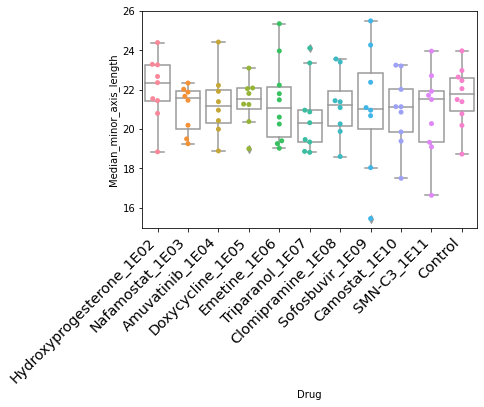

In [7]:
run_for_all()

In [54]:
path='E:/Data_Drug_Screening_CovidBox/Acquifer/20210903_drug_screen_FliV_Myl7R_ScreenSelectedP2/Export__ScreenSelectedP2'
list_P1=os.listdir(path)
#X=np.zeros([96,2048,2048])
#y=np.zeros([96,2048,2048,1])
#for c,i in enumerate(list_P1):
img=imread(os.path.join(path,list_P1[92])).astype(np.float32)
#img=skimage.transform.resize(img[:,:],(2048, 2048),anti_aliasing=False,mode='constant').astype(np.float32)
#inp=np.expand_dims(img,axis=0)
#out=model.predict(inp)
#X[c,:,:,]=inp
#y[c,:,:,]=out
#plt.imshow(out[0])


MAX_H007_1.tif


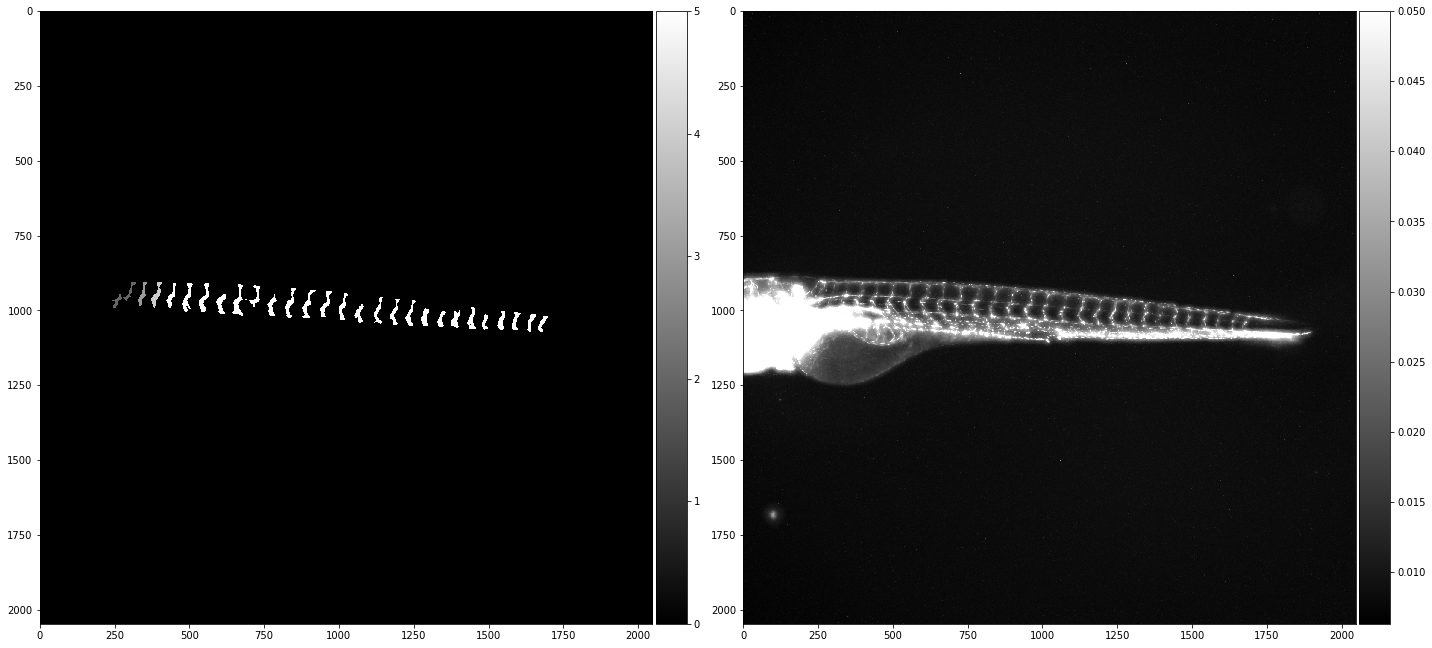

In [81]:
path='E:/Data_Drug_Screening_CovidBox/Acquifer/20210903_drug_screen_FliV_Myl7R_ScreenSelectedP2/Export__ScreenSelectedP2'
list_P1=os.listdir(path)
#X=np.zeros([96,2048,2048])
#y=np.zeros([96,2048,2048,1])
#for c,i in enumerate(list_P1):
n=90
print(list_P1[n])
img=imread(os.path.join(path,list_P1[n])).astype(np.float32)
inp=(np.expand_dims(img[1],axis=0)/np.max(img[1]))

out=model.predict(inp)
labels=skimage.morphology.remove_small_objects(skimage.morphology.label(out[0] > 0.45, background=None, return_num=False, connectivity=1),min_size=400)

plt.figure(figsize=(20,10))
plt.subplot(121)
imshow(labels,cmap="gray",vmax=5)
plt.subplot(122)
imshow(inp[0],vmax=0.05,cmap="gray")
plt.savefig("E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure4_Acq Example Results/example_ISVseg.tif")

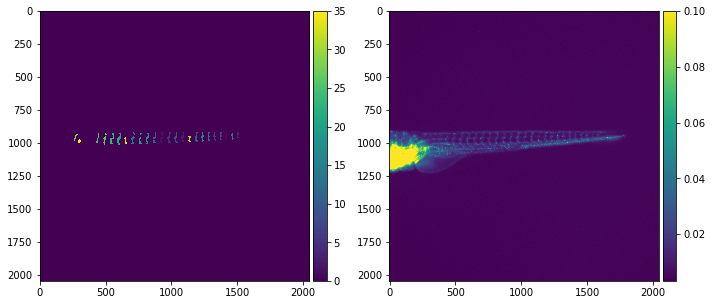

In [86]:
plt.figure(figsize=(10,10))
n_image=95
plt.subplot(121)
imshow(skimage.morphology.remove_small_objects(skimage.morphology.label(y[n_image]>0.45, background=None, return_num=False, connectivity=1),min_size=400))

plt.subplot(122)
imshow(X[n_image],vmax=0.1)
plt.show()

In [16]:
import pandas as pd

In [ ]:
df_f=pd.read_pickle("E:/Data_Drug_Screening_CovidBox/Acquifer/20210904_10th_session/20210903_drug_screen_FliV_Myl7R_ScreenSelectedP1/Measurements/",compression=None)

In [ ]:
fig, axs = plt.subplots(8, halflist, figsize=(100, 100))

for ax,images in zip(axs.flat,listImages):
    img=io.imread(path+images)
    ax.imshow(img[0], vmin=0, vmax=1500,cmap="gray")
    ax.set_title(images.replace("MAX_","").replace(".tif","").split("_")[1],fontsize=36)
plt.savefig("Plate_overview_GFP.tif",bbox_inches='tight')    

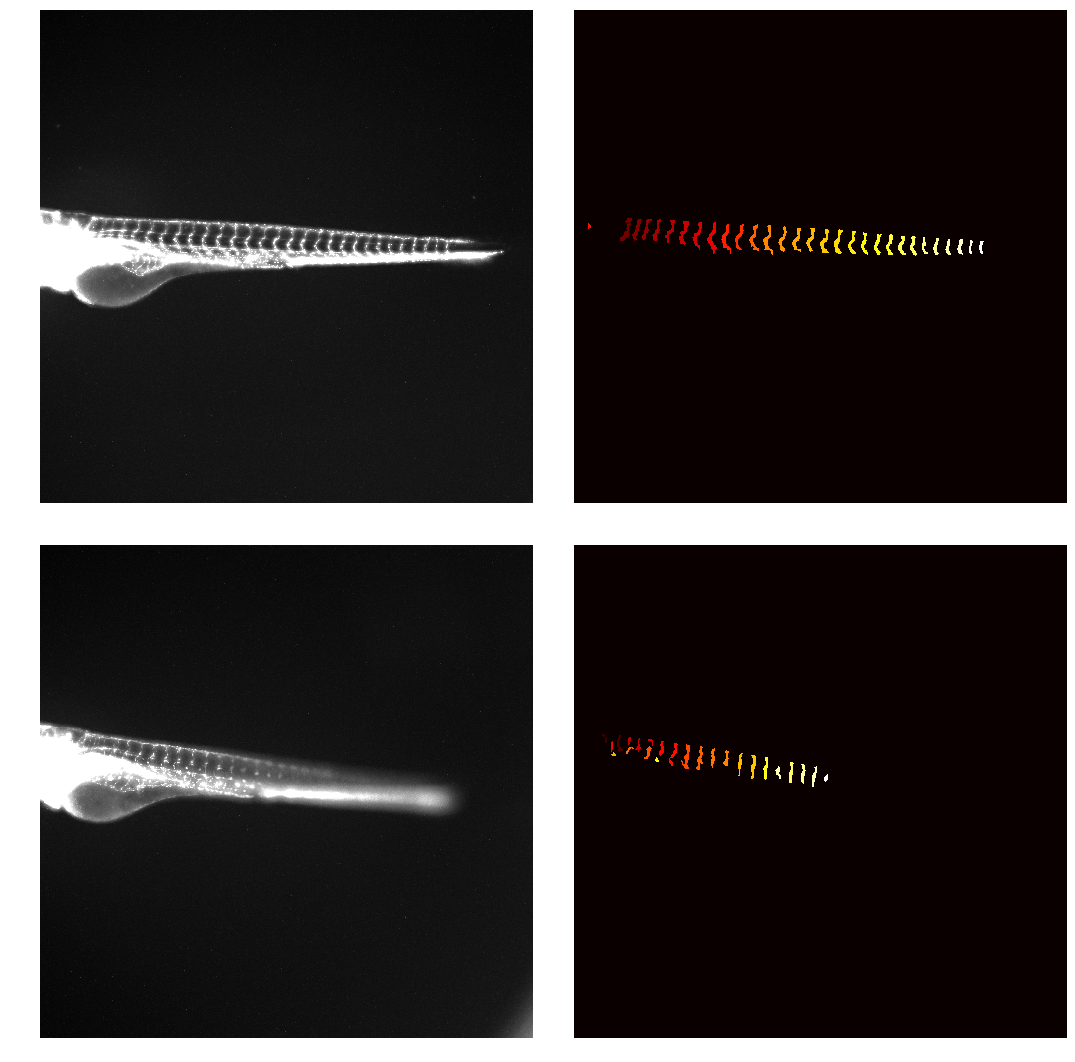

In [144]:
cmap_ = plt.cm.viridis
cmap_.set_bad(color='black')

plt.subplots(2,2,figsize=(15,15))
plt.tight_layout()

plt.subplot(221)
plt.axis('off')

plt.imshow(df_f["region_props"][90][0][0],cmap="gray",vmax=0.03)

plt.subplot(222)

plt.axis('off')
plt.imshow(df_f["region_props"][90][1],cmap="hot")


plt.subplot(223)
plt.axis('off')
plt.imshow(df_f["region_props"][60][0][0],cmap="gray",vmax=0.03)

plt.subplot(224)
plt.axis('off')
plt.imshow(df_f["region_props"][60][1],cmap="hot")
#plt.savefig("Sorafenib_ISV-zoom.png")

plt.show()


In [28]:
df_f.loc[ : , df_f.columns != 'region_props'][30:96]

,image_name,Well,Drug,Median_minor_axis_length,Median_major_axis_length,Count_ISV
30,MAX_C007_1.tif,C007,Ivermectin_1F05,21.180564,60.018791,24
31,MAX_C008_1.tif,C008,Ivermectin_1F05,20.555130,95.070997,31
32,MAX_C009_1.tif,C009,Ivermectin_1F05,19.346025,90.308959,29
33,MAX_C010_1.tif,C010,Ivermectin_1F05,17.686253,71.707225,27
34,MAX_C011_1.tif,C011,Ivermectin_1F05,18.481713,58.257544,22
35,MAX_C012_1.tif,C012,Ivermectin_1F05,19.221677,70.424600,25
36,MAX_D001_1.tif,D001,Indomethacin_1F06,14.814624,60.700942,36
37,MAX_D002_1.tif,D002,Indomethacin_1F06,22.984810,104.702607,29
38,MAX_D003_1.tif,D003,Indomethacin_1F06,22.522842,76.361186,31
39,MAX_D004_1.tif,D004,Indomethacin_1F06,21.808090,108.317871,30


In [211]:
alpha=0.05
df_test=df_stat.copy()
for i in df_test.columns:
    print([i])
    a,b =stats.kruskal(df_test["Control"],df_test[i].dropna(axis=0))
    print(a,b)
    if b < alpha:
        print("difference")
    else:
        print("no difference")

['Control']
0.0 1.0
no difference
['Fluphenazine_1H06']
0.5052631578947384 0.4771966199887694
no difference
['Haloperidol_1H07']
1.5 0.22067136191984324
no difference
['Imatinib_1H05']
0.9657142857142915 0.32575135447871234
no difference
['Lopinavir_1H04']
0.34285714285714874 0.5581846494226539
no difference
['Loratidine_1H09']
0.006666666666674814 0.9349253116420776
no difference
['Ozanimod_1H08']
0.2842105263157819 0.5939546753269194
no difference
['Pevonedistat_1H02']
0.5714285714285694 0.4496917979688917
no difference
['Posaconazole_1H10']
0.026666666666670835 0.8702827722810258
no difference
['Pyronaridine_1H11']
0.19736842105263008 0.6568534184528312
no difference
['Tetrandrine_1H03']
1.7763157894736779 0.1826023778113608
no difference


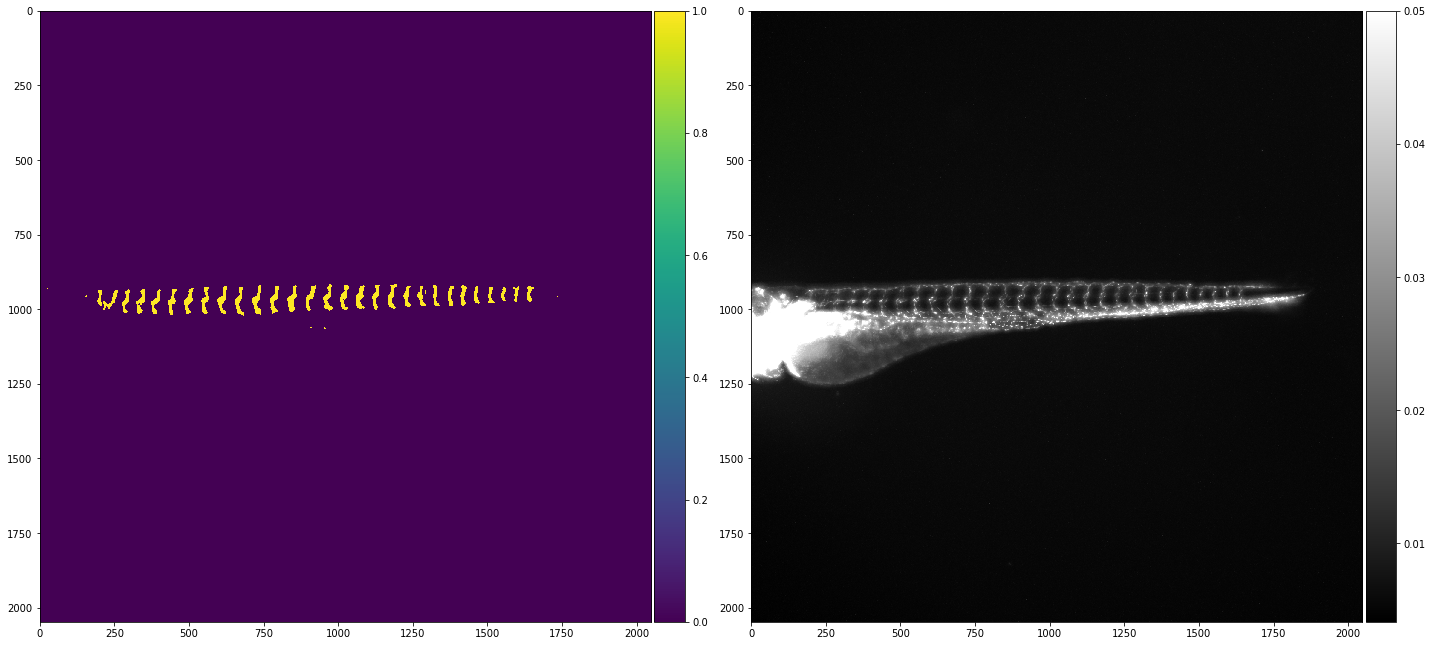

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(121)
imshow(p[0,:,:,0]>0.001)
plt.subplot(122)
imshow(img_array[0,:,:],cmap="gray",vmax=0.05)